This notebook demos using `SuperGlueWrapper.py`.

In [1]:
from models.matching import Matching
from models.utils import frame2tensor,make_matching_plot_fast
import cv2
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import pyplot as plt

device = 'cuda'
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': -1
        },
        'superglue': {
            'weights': 'indoor',
            'sinkhorn_iterations': 20,
            'match_threshold': 0.2,
        }
    }


def imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, model):
    valid = matches > -1    # array of t/f
    mkpts0 = kpts0[valid]   # if kpt not valid, disappear in mkpts
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])
    text = [
        'SuperGlue',
        'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
        'Matches: {}'.format(len(mkpts0))
    ]
    k_thresh = model.superpoint.config['keypoint_threshold']
    m_thresh = model.superglue.config['match_threshold']
    small_text = [
        'Keypoint Threshold: {:.4f}'.format(k_thresh),
        'Match Threshold: {:.2f}'.format(m_thresh),
        'Image Pair: {:06}:{:06}'.format(0, 1),
    ]
    out = make_matching_plot_fast(
        img_1, img_2, kpts0, kpts1, mkpts0, mkpts1, color, text,
        path=None, show_keypoints=True, small_text=small_text)

    plt.imshow(out)
    plt.show()

First try using `SuperGlue` class directly.

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


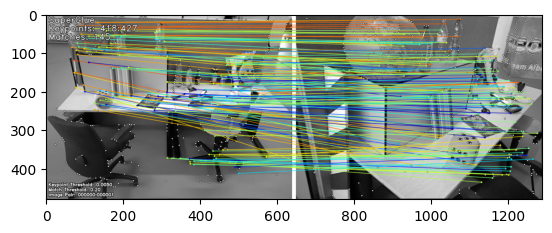

In [2]:
SuperGlue = Matching(config).eval().to(device)

img_1 = cv2.imread('./assets/freiburg_sequence/1341847980.722988.png', cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread('./assets/freiburg_sequence/1341847989.802890.png', cv2.IMREAD_GRAYSCALE)
img_3 = cv2.imread('./assets/freiburg_sequence/1341847995.870641.png', cv2.IMREAD_GRAYSCALE)
tensor_1 = frame2tensor(img_1, device)
tensor_2 = frame2tensor(img_2, device)

pred = SuperGlue({'image0': tensor_1, 'image1': tensor_2})
kpts0 = pred['keypoints0'][0].cpu().numpy()
kpts1 = pred['keypoints1'][0].cpu().numpy()
matches = pred['matches0'][0].cpu().numpy()
confidence = pred['matching_scores0'][0].detach().cpu().numpy()

imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, SuperGlue)

Then try using the wrapper and changing configs.

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


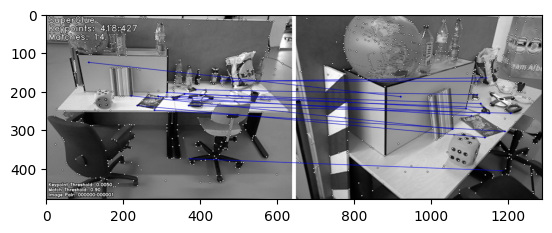

In [3]:
from models.SuperGlueWrapper import SuperGlueWrapper

wrapper = SuperGlueWrapper(match_threshold=0.9)
kpts0, matches, confidence, kpts1 = wrapper.forward_full(img_1, img_2)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)

One way is to use `forward_full` that goes through the whole pipeline to find keypoints and matching results on a pair of images. For a sequence of images, this creates computational redundancy.

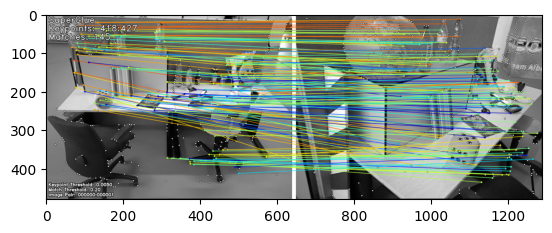

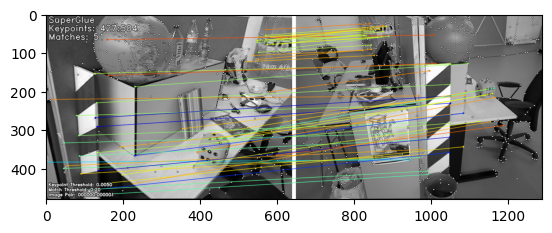

In [4]:
wrapper.set_config(match_threshold=0.2)
kpts0, matches, confidence, kpts1 = wrapper.forward_full(img_1, img_2)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)
kpts0, matches, confidence, kpts1 = wrapper.forward_full(img_2, img_3)
imshow_inline(img_2, img_3, kpts0, matches, confidence, kpts1, wrapper.model)

Another way is to use `forward_append` with `get_keypoints`. Here for the middle image, keypoints and descriptors are only calculated once.

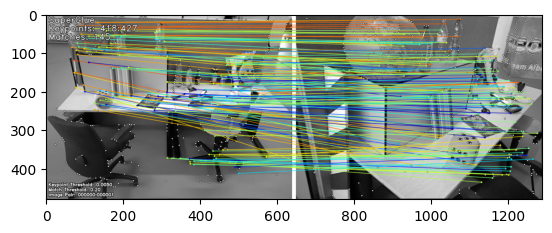

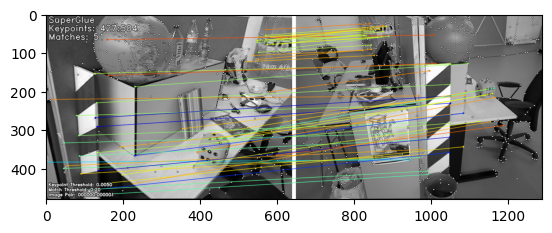

In [5]:
wrapper.get_keypoints(img_1)
kpts0, matches, confidence, kpts1 = wrapper.forward_append(img_2)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)
kpts0, matches, confidence, kpts1 = wrapper.forward_append(img_3)
imshow_inline(img_2, img_3, kpts0, matches, confidence, kpts1, wrapper.model)